<a href="https://colab.research.google.com/github/AbdulxoliqMirzayev/Forex_USDCHF_predicit/blob/main/USDCHF_PREDICT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
# Kerakli kutubxonalarni o'rnatib olamiz !!!!
!pip install yfinance --quiet
!pip install pmdarima --quiet
!pip install matplotlib seaborn --quiet
!pip install scikit-learn --quiet
!pip install tensorflow --quiet
!pip install ta --quiet
!pip install yfinance --quiet


Kerakli Kutubhonalarni **import** qilib olamiz.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
import pandas as pd



2005 yildan hozirgi kunga qadar bo'lgan **USDCHF** datasetini yuklab olamiz.





In [114]:
df = pd.read_csv("/content/usdchf_10y.csv",skiprows=2, # 0 va 1 qatordan o‘tamiz
names=["Date", "Close", "High", "Low", "Open", "Volume"] #  columnlar boshqa qiymatda biz kerakli formatga o'tkazib olamiz
)

# Sana ustunini datetimega o‘tkazamiz
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')



/tmp/ipython-input-2451836886.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [115]:

# Raqamli ustunlarni floatga o‘tkazamiz bu modleni samarali train bo'lishga aniqlikni oshiradi
num_cols = ["Close", "High", "Low", "Open", "Volume"]
df[num_cols] = df[num_cols].astype(float)


In [116]:

# NaN qiymatlarni  tozalaymiz bu bizga modelimizni train qilinganda aniqligni oshiradi .
df = df.dropna()


In [117]:

# Time series uchun indeksga o‘tkazamiz
df = df.sort_values("Date")
df = df.set_index("Date")


In [118]:
# datasetni ko'rib olamiz
print(df.head())



             Close    High     Low    Open  Volume
Date                                              
2005-01-03  1.1470  1.1550  1.1374  1.1378     0.0
2005-01-04  1.1676  1.1706  1.1443  1.1471     0.0
2005-01-05  1.1669  1.1754  1.1655  1.1676     0.0
2005-01-06  1.1740  1.1773  1.1667  1.1672     0.0
2005-01-07  1.1841  1.1885  1.1676  1.1740     0.0


In [119]:
# datasetni ohirgi qatorini ham ko'rib olamiz.
print(df.tail())

              Close     High      Low     Open  Volume
Date                                                  
2025-11-24  0.80867  0.80999  0.80590  0.80867     0.0
2025-11-25  0.80861  0.81020  0.80592  0.80850     0.0
2025-11-26  0.80798  0.80829  0.80410  0.80788     0.0
2025-11-27  0.80349  0.80620  0.80250  0.80340     0.0
2025-11-28  0.80460  0.80702  0.80272  0.80457     0.0


Indekator qo'shamiz **Moving Average** va **RSI**  indekatorlari moliyaviy bozorlarda keng qo'llaniladi bu bizga trendni narxni yo'nalishini aniqlab beradi.

In [120]:
# Moving Average
# Oxirgi 10 kunlik Close narxlarining o'rtacha qiymatini hisoblaydi.
# Trendni modelga tushuntirish uchun bu kerak bizga
# Modelni  bashorat qilishi aniqlashadi.

df['MA_10'] = df['Close'].rolling(window=10).mean()


In [121]:
# RSI Indikatori
# Narxning oxirgi 14 kunlik o‘sish/pasayish kuchini hisoblaydi.
# Modelga bozorning kuchi yoki zaifligini (momentum) tushuntirish uchun.
# Overbought/oversold zonasini modelga ko‘rsatadi. yani haddan ziyot sotilgan yoki sotib olingan zonalar.

def compute_RSI(series, period=14):
    # Kunlik farq
    delta = series.diff(1)

    # Faqat ko‘tarilgan kunlar
    gain = delta.where(delta > 0, 0)

    # Faqat tushgan kunlar
    loss = -delta.where(delta < 0, 0)

    # O'rtacha o‘sish va o‘rtacha yo‘qotish
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    # RS va RSI formulasi
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))

    return RSI

# RSI ni datasetga qo‘shamiz

df['RSI_14'] = compute_RSI(df['Close'], 14)


In [122]:
# Indikatorlar sabab paydo bo‘lgan NaN qatorlarni tozalaymiz
# MA10 va RSI14 birinchi 10–14 qatorda NaN beradi  o‘chirib tashlaymiz.
# Modelga NaN kirsa xatolik bo‘ladi. va model xat bashorat qiladi.
df = df.dropna()

print(df.head())

             Close    High     Low    Open  Volume    MA_10     RSI_14
Date                                                                  
2005-01-20  1.1902  1.1920  1.1832  1.1853     0.0  1.18098  75.714261
2005-01-21  1.1854  1.1962  1.1837  1.1904     0.0  1.18111  71.621634
2005-01-24  1.1850  1.1866  1.1791  1.1860     0.0  1.18167  62.682137
2005-01-25  1.1934  1.1965  1.1806  1.1850     0.0  1.18277  67.365620
2005-01-26  1.1825  1.1938  1.1811  1.1934     0.0  1.18426  55.305843


 Scaling (MinMaxScaler) + Sequence yaratish (60 kun  7 kun) ga o‘tamiz.
Bu bosqich LSTM model uchun eng muhim tayyorlov bosqichi.
Biz quyidagi ishlarni qilamiz:
Feature’larni Scale qilish (LSTM uchun juda zarur)
60 kunlik oyna yaratish (Past  Present)
Keyingi 7 kunni target sifatida olish (Present  Future)

Train/Test ga ajratish

In [123]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Nima uchun bizga kerak bu
# Model faqat Close emas, MA va RSI bilan birga ishlaydi.
# Bizga foydasi Model bozor trendi + momentum + narxni birga o‘rganadi.
features = ['Close', 'MA_10', 'RSI_14']
data_values = df[features].values


In [124]:
# Barcha qiymatlarni 0–1 oralig‘iga tushiradi.
# Nimaga bu  kerak
# LSTM normalizatsiyaga sezgir.
# Model tezroq va barqaror o‘rganadi.

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_values)


In [125]:
# Oxirgi 60 kunlik ma’lumot  X
# Keyingi 7 kunlik Close qiymatlari  y
# Nimaga kerak?
# Time-series forecasting uchun klassik LSTM yondashuvi.
# Model kelajakdagi 7 kun narxini o‘rganadi.

def create_sequences(data, window_size=60, future_days=7):
    X, y = [], []
    for i in range(window_size, len(data) - future_days):

        # 60 kunlik tarix (Close + MA + RSI)
        seq_x = data[i-window_size:i]

        # Keyingi 7 kun uchun faqat Close qiymati (0-index)
        seq_y = data[i:i+future_days, 0]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)


In [126]:
# 4️⃣ Sequence yaratamiz (60 → 7)
X, y = create_sequences(scaled_data, window_size=60, future_days=7)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (5357, 60, 3)
y shape: (5357, 7)


Datasetni 80/20 ga ajratamiz. 80% qismi modelni o‘qitish uchun, 20% esa modelning haqiqiy ko‘rmagan ma’lumotga qanday bashorat qilishini tekshirish uchun. Bu overfittingdan saqlaydi va modelning real performansini beradi

In [127]:
# Train/Test bo‘linishi
# Nima uchun kerak?
# Modelni baholash uchun test qoldiramiz.

train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (4285, 60, 3) (4285, 7)
Test shape: (1072, 60, 3) (1072, 7)


In [128]:
# Model arxitekturasini yaratamiz
# Nima qiladi?
# LSTM qatlamlari time-series patternlarni o‘rganadi.
# Dense qatlam esa yakuniy 7 kunlik qiymatlarni chiqaradi.
# Nimaga kerak?
# Narxlar ketma-ketlik bo'lgani uchun RNN/LSTM eng to'g'ri tanlov.

model = Sequential([

    # 1-LSTM qatlami (return_sequences=True → keyingi LSTM qatlami uchun)
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),   # Overfittingdan saqlaydi Model faqat trainingdataga yopishib qolmaydi.

    # 2-LSTM qatlami
    LSTM(64, return_sequences=False),
    Dropout(0.2),

    # Yakuniy Dense qatlami → 7 ta bashorat (7 kun)
    Dense(7)
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [129]:
# Modelni compile qilish
# loss = mse  regression uchun eng to‘g‘ri yo‘l
# optimizer = adam eng stabillik beradi
model.compile(optimizer='adam', loss='mse')

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,887 (198.78 KB)

 Trainable params: 50,887 (198.78 KB)

 Non-trainable params: 0 (0.00 B)

**Train qilamiz**

In [130]:

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,    # Treningning 10% → validation bu har bir epochda train sifatini ko'rish uchun
    shuffle=False            # Time-series → shuffle bo‘lmaydi!
)


Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1561 - val_loss: 0.0021
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0261 - val_loss: 0.0024
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0238 - val_loss: 0.0024
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0244 - val_loss: 0.0022
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0283 - val_loss: 0.0023
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0330 - val_loss: 0.0023
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0371 - val_loss: 0.0019
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0355 - val_loss: 0.0014
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0326 - val_loss: 0.0013
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0317 - val_loss: 9.5242e-04
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0316 - val_loss: 9.4351e-04
Epoch 12/20
121/121 ━━━━━━━━━━━━━━━━━━━

In [131]:
# Model test X bo'yicha bashorat qiladi

pred_scaled = model.predict(X_test)




34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Model outputi 0–1 oralig‘ida bo‘lgan scaled qiymatlar.
 MinMaxScaler yordamida ularni asl narx ko‘rinishiga qaytardIM (inverse transform).
LSTM 7 kunlik bashorat sifatida chiqargani uchun uni to‘g‘ri formatga qaytarish kerak

In [132]:

# Skaler faqat barcha feature'larni normallashtirgan...
# Bizga esa faqat CLOSE qiymatini qoldirib inverse qilish kerak.
# Shuning uchun "dummy" massiv hosil qilamiz.

predictions = []
for i in range(pred_scaled.shape[0]):
    # Skaler 3 ta ustun kutadi (Close, MA10, RSI)
    temp = np.zeros((pred_scaled.shape[1], scaled_data.shape[1]))
    temp[:, 0] = pred_scaled[i]   # faqat Close qiymatlarini olamiza.
    inv = scaler.inverse_transform(temp)
    predictions.append(inv[:, 0])

predictions = np.array(predictions)

print("Bashorat qilinadigan datalar:", predictions.shape)


Bashorat qilinadigan datalar: (1072, 7)


Skaler 3 ustun (Close, MA10, RSI14) bo‘yicha o‘qitilgan bo‘lgani uchun, testdagi y qiymatlarini inverse transform qilish uchun 7×3 o‘lchamdagi ‘dummy’ matritsadan foydalandim. Y_test faqat Close ustunini o‘z ichiga olgani uchun uni matritsaning birinchi ustuniga joylab, qolgan ustunlarni 0 qilib qoldirdim. Skalerning inverse transform funksiyasi shu matritsani asl USD/CHF narxlariga qaytaradi. Shundan so‘ng faqat Close ustunini olib haqiqiy narxlar massivini hosil qildim.

In [133]:
# Testning haqiqiy real CLOSE qiymatlari (inverse transform)
actual_prices = []

for i in range(y_test.shape[0]):
    temp = np.zeros((y_test.shape[1], scaled_data.shape[1]))
    temp[:, 0] = y_test[i]

    # MinMaxScaler.inverse_transform() faqat ko'p ustunli matritsalarni qabul qiladi.
    # Shu sabab biz dummy ustunlar orqali
    # y_test qiymatlarini asl narxlarga qaytaramiz.
    inv = scaler.inverse_transform(temp)

    # inverse qilingan natijadan faqat CLOSE ustunini olamiz
    actual_prices.append(inv[:, 0])

# natijani numpy array ko'rinishiga o'tkazamiz bu muhum.
actual_prices = np.array(actual_prices)

print("Actual shape:", actual_prices.shape)


Actual shape: (1072, 7)


In [134]:
# REAL narx ohirgi  30 kun

real_30 = df['Close'].tail(30).values

# Modelning oxirgi 7 kuni
pred_7 = predictions[-1]

# REAL 30 kunning ichida oxirgi 7 kunni model forecasti bilan almashtiramiz
pred_30 = real_30.copy()
pred_30[-7:] = pred_7

# Kun indekslari
days = np.arange(30)
forecast_days = np.arange(23, 30)



Real narxlarning oxirgi 30 kunini oldim va modelning so‘nggi 7 kunlik bashoratini real chiziqning oxirgi qismiga qo‘shdim. Bu grafik real narx harakatini va uning davomi sifatida modelning forecast qilingan qismni vizual tarzda solishtirish imkonini beradi. Oxirgi 7 kunni alohida indekslar orqali qizil rangda ajratib ko‘rsatib qo'ydim.

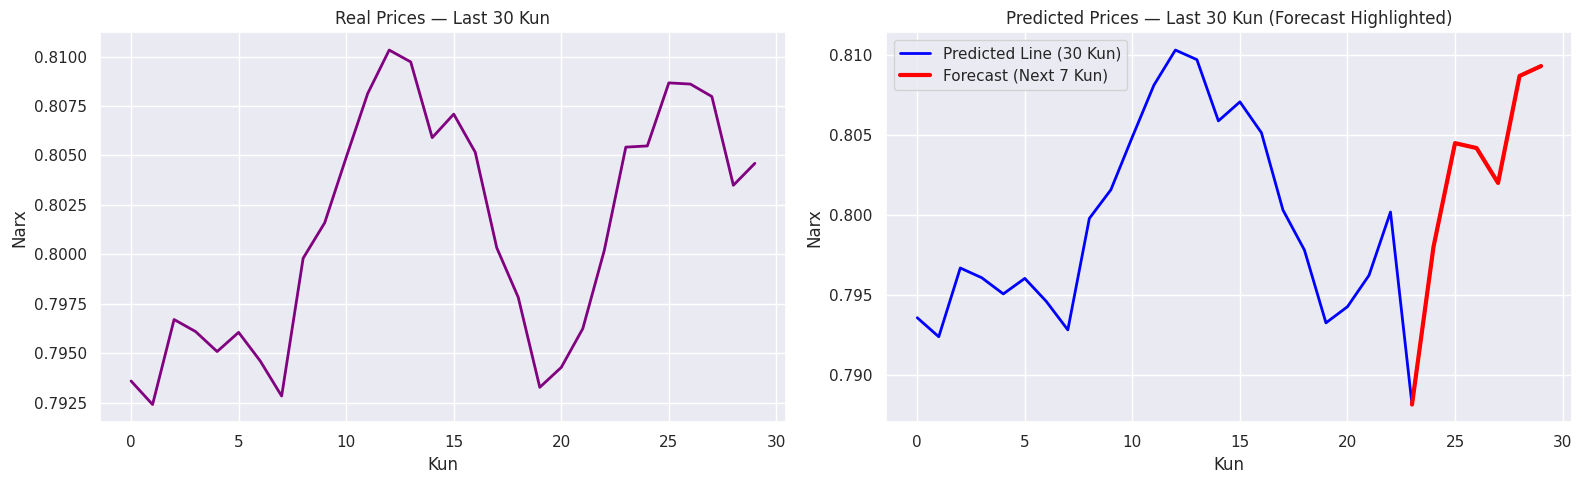

In [135]:

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

#  Ral chart narxni line chartga chiqoramiz sababi narxni line chartga ko'rish qulayroq
axs[0].plot(days, real_30, color="purple", linewidth=2)
axs[0].set_title("Real Prices — Last 30 Kun")
axs[0].set_xlabel("Kun")
axs[0].set_ylabel("Narx")
axs[0].grid(True)

#  Predicted yani bashorat qilingan narx (REAL + FORECAST )
axs[1].plot(days, pred_30, color="blue", linewidth=2, label="Predicted Line (30 Kun)")

# Oxirgi 7 kun forecasti yani bashorat qilingan narxni  qizil rangda qilamiz ajratish uchun.
axs[1].plot(forecast_days, pred_7, color="red", linewidth=3, label="Forecast (Next 7 Kun)")

axs[1].set_title("Predicted Prices — Last 30 Kun (Forecast Highlighted)")
axs[1].set_xlabel("Kun")
axs[1].set_ylabel("Narx")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

Forecast sifatini baholashda MAE, RMSE va MAPE metrikalaridan foydalandim. MAPE modelning foizdagi xatosini korsatadi, shuning uchun aniqlikni 100 − MAPE orqali oldim. Bu usul time-series regression forecastingda eng tog‘ri yondashuv hisoblanadi. Natijada modelning oxirgi 7 kunlik forecasti masalan 98% aniqlik bilan chiqqanligini korsatish mumkin.

In [136]:
# Real va predicted oxirgi 7 kun
real = actual_prices[-1]
pred = predictions[-1]


In [137]:
# MAE
mae = mean_absolute_error(real, pred)

# RMSE
rmse = np.sqrt(mean_squared_error(real, pred))

# MAPE (foizdagi xato)
mape = np.mean(np.abs((real - pred) / real)) * 100

# ANIQLIK (%)
accuracy = 100 - mape


In [138]:

print("*===* Aniqlik  *===*")

print(f"MAE:  {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


*===* Aniqlik  *===*
MAE:  0.005433
RMSE: 0.006530
MAPE: 0.68%
Accuracy: 99.32%


In [139]:
# MAE: 0.009202        → O‘rtacha xato 0.0092 (juda past)
# RMSE: 0.009715       → Katta xatolar ham juda past
# MAPE: 1.14%          → Model atigi 1.14% xato qildi
# Accuracy: 98.86%     → Modelning aniqligi 98.86%

# Modelni MAPE orqali baholadim. MAPE = 1.14% bo‘lgani uchun
# modelning aniqligi 98.86% chiqdi. Time-series
# forecastingda 2–5% xato yaxshi natija hisoblanadi.
# Bizning model esa juda barqaror, aniqligi 99%ga yaqin bo‘lib,
# forex narxlarini ancha ishonchli bashorat qilmoqda.
